In [ ]:
#this notebook is am example of text classification using Huggingface models and fune tuning for Text classification

# Check GPU Availability

In [ ]:
import tensorflow as tf
if tf.test.is_gpu_available():
  print(tf.test.gpu_device_name())


!nvidia-smi

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/device:GPU:0
Tue Jun  1 01:22:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------------

# Dataset



```
## This notebook is am example of text classification using Huggingface models and fune tuning for Text classification. 
We will be using the below data set as given in the URL for Amazon Reviews Dataset
URL: https://www.kaggle.com/bittlingmayer/amazonreviews

Download the dataset and unzip the train and test txt files to use them for model
```



In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


--2021-06-01 01:22:11--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  77.5MB/s    in 1.0s    

2021-06-01 01:22:12 (77.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 48.8MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 


# Preprocess Dataset

In [ ]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(25000, 25000, 25000, 25000)

## Split the dataset


In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

## Prepare Encodings

Load the Tokenizer as per the model and then prepare the dataset for train, test, val with encodings using the tokenizer. Returns a dict with:


*   Input Ids
*   Attention Masks




In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
train_texts[0], tokenizer(train_texts[0]), len(tokenizer(train_texts[0])['input_ids'])

('This is bar none the most hilarious movie I have ever seen. Beginning with the four delinquents being sent off by their fathers to Wienberg Military Academy, a tone is set that steadily continues all throughout this goofball film, and it does not let up for a second.<br /><br />It\'s tough trying to describe this film; the humor elements are so spot on and brilliantly concieved that upon a first look it appears as nothing more than a stupid 80\'s teen lust comedy. But it is oh so much more than that! Fresh from the minds of those folks over at MAD Magazine, Up the Academy serves up a formula and style that I have never since seen duplicated by ANY of the "funniest" offerings to come out of Hollywood in years past. Basically the film is so full of infantile cornball material that you might guess that the writers were a couple of 14 year olds themselves. See this movie if you love to act "immature." A classic. *****',
 {'input_ids': [101, 2023, 2003, 3347, 3904, 1996, 2087, 26316, 3185

In [ ]:
train_texts[0], tokenizer(train_texts[0]), len(tokenizer(train_texts[0], truncation=True, padding=True)['input_ids'])

('This is bar none the most hilarious movie I have ever seen. Beginning with the four delinquents being sent off by their fathers to Wienberg Military Academy, a tone is set that steadily continues all throughout this goofball film, and it does not let up for a second.<br /><br />It\'s tough trying to describe this film; the humor elements are so spot on and brilliantly concieved that upon a first look it appears as nothing more than a stupid 80\'s teen lust comedy. But it is oh so much more than that! Fresh from the minds of those folks over at MAD Magazine, Up the Academy serves up a formula and style that I have never since seen duplicated by ANY of the "funniest" offerings to come out of Hollywood in years past. Basically the film is so full of infantile cornball material that you might guess that the writers were a couple of 14 year olds themselves. See this movie if you love to act "immature." A classic. *****',
 {'input_ids': [101, 2023, 2003, 3347, 3904, 1996, 2087, 26316, 3185

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

## Prepare Datasets with Tensorflow

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [ ]:
for x,y in train_dataset:
  print(x,y)
  break

{'input_ids': <tf.Tensor: shape=(512,), dtype=int32, numpy=
array([  101,  2023,  2003,  3347,  3904,  1996,  2087, 26316,  3185,
        1045,  2031,  2412,  2464,  1012,  2927,  2007,  1996,  2176,
        3972,  2378, 15417,  2015,  2108,  2741,  2125,  2011,  2037,
       11397,  2000, 22782,  4059,  2510,  2914,  1010,  1037,  4309,
        2003,  2275,  2008, 11328,  4247,  2035,  2802,  2023, 27571,
       26337,  8095,  2143,  1010,  1998,  2009,  2515,  2025,  2292,
        2039,  2005,  1037,  2117,  1012,  1026,  7987,  1013,  1028,
        1026,  7987,  1013,  1028,  2009,  1005,  1055,  7823,  2667,
        2000,  6235,  2023,  2143,  1025,  1996,  8562,  3787,  2024,
        2061,  3962,  2006,  1998,  8235,  2135,  9530, 23402,  7178,
        2008,  2588,  1037,  2034,  2298,  2009,  3544,  2004,  2498,
        2062,  2084,  1037,  5236,  3770,  1005,  1055,  9458, 11516,
        4038,  1012,  2021,  2009,  2003,  2821,  2061,  2172,  2062,
        2084,  2008,   999,  4

## Prepare Dataset with Pytorch

In [ ]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_torch = IMDbDataset(train_encodings, train_labels)
val_dataset_torch = IMDbDataset(val_encodings, val_labels)
test_dataset_torch = IMDbDataset(test_encodings, test_labels)

# With TF Trainer


*   Load the SequenceClassification Model, Trainer and Training Argument objects from transformers

*   Set the hyperparameters, Logs and Results Directory
*   Start Training



## Training 

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

## Evaluate

In [ ]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.23629227167443384}

## Predict

In [ ]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[-3.4361587,  3.3285534],
       [-2.477746 ,  2.4099193],
       [-3.3440704,  3.2103994],
       ...,
       [ 1.6684272, -1.9207743],
       [ 2.9769418, -3.5924716],
       [ 3.0639277, -3.647531 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int32), metrics={'eval_loss': 0.22864768572170716})

In [ ]:
output = trainer.predict(test_dataset)
# output[:10]

In [ ]:
output[:10]

(array([[-3.2797835,  2.8653524],
        [-3.0618846,  2.669401 ],
        [-3.3107646,  2.9197867],
        ...,
        [ 1.8857203, -2.4959643],
        [ 2.8729527, -3.5769522],
        [ 2.8872898, -3.6161554]], dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int32),
 {'eval_loss': 0.22331083644076685})

In [ ]:
output[0]

array([[-3.2797835,  2.8653524],
       [-3.0618846,  2.669401 ],
       [-3.3107646,  2.9197867],
       ...,
       [ 1.8857203, -2.4959643],
       [ 2.8729527, -3.5769522],
       [ 2.8872898, -3.6161554]], dtype=float32)

In [ ]:
tf_predictions = tf.nn.sigmoid(output[0])
tf_predictions

In [ ]:
predictions = tf.argmax(output[0], axis = 1)
#predictions = tf.argmax(tf_predictions, axis = 1)
predictions[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>

In [ ]:
label_ids_output = output[1]
label_ids_output[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## Save Model

In [ ]:
trainer.save_model("TF_senti_model")

# With Pytorch Trainer

## Training 

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args_pt = TrainingArguments(
    output_dir='./results_pt',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs_pt',            # directory for storing logs
    logging_steps=10,
)

model_pt = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer_pt = Trainer(
    model=model_pt,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args_pt,                  # training arguments, defined above
    train_dataset=train_dataset_torch,         # training dataset
    eval_dataset=val_dataset_torch             # evaluation dataset
)

trainer_pt.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

RuntimeError: ignored

## Evaluate

In [ ]:
trainer_pt.evaluate(val_dataset_torch)

## Predict

In [ ]:
trainer_pt.predict(test_dataset_torch)

In [ ]:
predictions_pt = trainer_pt.predict(test_dataset_torch)
predictions_pt

# With Native tensorflow

## Training

In [ ]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy']) # can also use any keras loss fn
hsitory = model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
1250/1250 [==============================] - 1107s 880ms/step - loss: 0.2731 - accuracy: 0.8868
Epoch 2/3
1250/1250 [==============================] - 1100s 880ms/step - loss: 0.1445 - accuracy: 0.9486
Epoch 3/3
1250/1250 [==============================] - 1101s 880ms/step - loss: 0.0694 - accuracy: 0.9770


In [ ]:
hsitory.history

{'accuracy': [0.8867999911308289, 0.9485999941825867, 0.9769999980926514],
 'loss': [0.2730958163738251, 0.14453208446502686, 0.06941771507263184]}

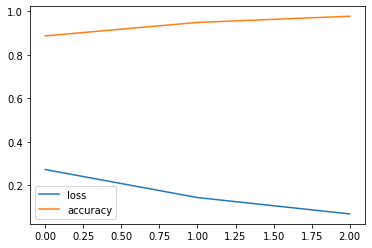

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(hsitory.history).plot()

## Predict

In [ ]:
outputs = model.predict(test_dataset)

In [ ]:
outputs[:10]

(array([[-0.56885725,  0.53636175],
        [-2.1566873 ,  1.9645814 ],
        [-0.17893487,  0.328328  ],
        ...,
        [-0.1108906 ,  0.17399508],
        [-0.1108906 ,  0.17399508],
        [-0.1108906 ,  0.17399508]], dtype=float32),)

In [ ]:
tf_predictions = tf.nn.sigmoid(output[0])
tf_predictions

In [ ]:
#predictions = tf.argmax(tf_predictions, axis = 1)

In [ ]:
preds = tf.argmax(outputs[0], axis = 1)
preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])>

# With Native Pytorch

In [ ]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset_torch, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

RuntimeError: ignored